<a href="https://colab.research.google.com/github/AudriBanik/finalproject/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary packages
!pip install numpy pandas torch matplotlib scipy tqdm

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import os

# Download datasets
if not os.path.exists("PEMS-BAY.csv"):
    print("Downloading PEMS-BAY dataset...")
    !wget -O PEMS-BAY.csv "https://zenodo.org/records/5146275/files/PEMS-BAY.csv?download=1"

if not os.path.exists("METR-LA.csv"):
    print("Downloading METR-LA dataset...")
    !wget -O METR-LA.csv "https://zenodo.org/records/5146275/files/METR-LA.csv?download=1"

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Helper function to dynamically determine the number of nodes
def get_num_nodes(csv_file):
    data = pd.read_csv(csv_file).select_dtypes(include=[np.number])
    return data.shape[1]

# Data Preprocessing
def preprocess_csv(filepath, seq_length=12, pred_length=12, sample_frac=1.0):
    traffic_data = pd.read_csv(filepath)
    traffic_data = traffic_data.select_dtypes(include=[np.number]).values

    if sample_frac < 1.0:
        num_samples = int(len(traffic_data) * sample_frac)
        traffic_data = traffic_data[:num_samples]

    mean = traffic_data.mean()
    std = traffic_data.std()
    traffic_data = (traffic_data - mean) / std

    num_samples = traffic_data.shape[0]
    num_train = int(num_samples * 0.6)
    num_val = int(num_samples * 0.2)
    train_data = traffic_data[:num_train]
    val_data = traffic_data[num_train:num_train + num_val]
    test_data = traffic_data[num_train + num_val:]

    def create_sequences(data):
        X, Y = [], []
        for i in range(len(data) - seq_length - pred_length):
            X.append(data[i:i + seq_length])
            Y.append(data[i + seq_length:i + seq_length + pred_length])
        return np.array(X), np.array(Y)

    X_train, Y_train = create_sequences(train_data)
    X_val, Y_val = create_sequences(val_data)
    X_test, Y_test = create_sequences(test_data)

    return (
        TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device),
                      torch.tensor(Y_train, dtype=torch.float32).to(device)),
        TensorDataset(torch.tensor(X_val, dtype=torch.float32).to(device),
                      torch.tensor(Y_val, dtype=torch.float32).to(device)),
        TensorDataset(torch.tensor(X_test, dtype=torch.float32).to(device),
                      torch.tensor(Y_test, dtype=torch.float32).to(device)),
    )

# Models
class GRUModel(nn.Module):
    def __init__(self, num_nodes, hidden_size, layers=1):
        super().__init__()
        self.gru = nn.GRU(num_nodes, hidden_size, num_layers=layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_nodes)

    def forward(self, x):
        _, h_n = self.gru(x)
        return self.fc(h_n[-1])

class GRUWithGN(nn.Module):
    def __init__(self, adjacency_matrix, num_nodes, hidden_size=64):
        super().__init__()
        self.adjacency = nn.Parameter(torch.tensor(adjacency_matrix, dtype=torch.float32), requires_grad=False)
        self.gru = nn.GRU(num_nodes, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, num_nodes)  # Project GRU output to node-specific features
        self.fc2 = nn.Linear(num_nodes, 256)  # MLP layer
        self.fc3 = nn.Linear(256, num_nodes)  # Output layer

    def forward(self, x):
        # Get GRU hidden states
        _, h_n = self.gru(x)  # h_n: (num_layers, batch_size, hidden_size)
        h_n = h_n[-1]  # Use the last layer's hidden state: (batch_size, hidden_size)

        # Project to node space
        node_features = self.fc1(h_n)  # (batch_size, num_nodes)

        # Apply adjacency matrix
        node_features = torch.einsum('ij,bj->bi', self.adjacency, node_features)  # (batch_size, num_nodes)

        # Pass through MLP
        h = torch.relu(self.fc2(node_features))  # (batch_size, 256)
        return self.fc3(h)  # (batch_size, num_nodes)


class GRUFedAvg(GRUModel):
    pass

class GRUWithFMTL(nn.Module):
    def __init__(self, num_nodes, hidden_size, adjacency_matrix, lambda_reg=0.1):
        super().__init__()
        self.gru = nn.GRU(num_nodes, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_nodes)
        self.adjacency = nn.Parameter(torch.tensor(adjacency_matrix, dtype=torch.float32), requires_grad=False)
        self.lambda_reg = lambda_reg

    def forward(self, x):
        _, h = self.gru(x)  # h: (1, batch_size, hidden_size)
        output = self.fc(h.squeeze(0))  # output: (batch_size, num_nodes)
        return output

    def regularization_loss(self, output):
        # Compute the Laplacian matrix
        laplacian = torch.diag(self.adjacency.sum(dim=1)) - self.adjacency

        # Validate dimensions
        if output.shape[1] != self.adjacency.shape[0]:
            raise ValueError(
                f"Output dimensions {output.shape} do not match adjacency matrix dimensions {self.adjacency.shape}."
            )

        # Compute the trace regularization term
        return self.lambda_reg * torch.trace(output @ laplacian @ output.T)


class CNFGNN(nn.Module):
    def __init__(self, adjacency_matrix, num_nodes, hidden_size=64):
        """
        A Graph Neural Network model for traffic prediction that uses an adjacency matrix
        for spatial dependency aggregation.

        Args:
            adjacency_matrix (np.ndarray or torch.Tensor): The adjacency matrix (num_nodes x num_nodes).
            num_nodes (int): Number of nodes in the graph.
            hidden_size (int): Size of the hidden layer in the MLP.
        """
        super().__init__()

        # Ensure the adjacency matrix is a torch.Tensor
        if not isinstance(adjacency_matrix, torch.Tensor):
            adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.float32)

        # Register the adjacency matrix as a parameter without gradients
        self.adjacency = nn.Parameter(adjacency_matrix, requires_grad=False)
        self.num_nodes = num_nodes

        # Define the fully connected layers
        self.fc1 = nn.Linear(num_nodes, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_nodes)

    def forward(self, x):
        """
        Forward pass of the CNFGNN model.
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_length, num_nodes).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_nodes).
        """
        print(f"Adjacency matrix shape: {self.adjacency.shape}")
        print(f"Input tensor shape: {x.shape}")

        # Validate input dimensions
        if x.size(-1) != self.num_nodes:
            raise ValueError(
                f"Input last dimension {x.size(-1)} does not match the number of nodes {self.num_nodes}."
            )

        # Apply adjacency matrix to each time step
        x = torch.einsum('ij,bjk->bik', self.adjacency, x)

        # Aggregate over the temporal dimension
        x = x.mean(dim=1)

        # Pass through MLP
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x



def compute_adjacency_from_csv(csv_file, method='correlation', threshold=0.5):
    data = pd.read_csv(csv_file).select_dtypes(include=[np.number])
    num_nodes = data.shape[1]
    if method == 'fully_connected':
        adjacency = np.ones((num_nodes, num_nodes))
        np.fill_diagonal(adjacency, 0)
    elif method == 'correlation':
        correlation_matrix = np.corrcoef(data.values, rowvar=False)
        adjacency = (np.abs(correlation_matrix) > threshold).astype(float)
        np.fill_diagonal(adjacency, 0)
    elif method == 'distance':
        from scipy.spatial.distance import pdist, squareform
        distances = squareform(pdist(data.T, metric='euclidean'))
        adjacency = np.exp(-distances)
        np.fill_diagonal(adjacency, 0)
    else:
        raise ValueError(f"Unsupported method: {method}.")
    return adjacency


# RMSE Evaluation
def evaluate_rmse(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            output = model(X_batch)
            target = Y_batch.mean(dim=1)
            if output.dim() == 3:
                output = output.mean(dim=1)
            y_true.extend(target.cpu().numpy().flatten())
            y_pred.extend(output.cpu().numpy().flatten())
    return np.sqrt(mean_squared_error(y_true, y_pred))

def train_gru_fedavg(num_nodes, train_loader, test_loader, epochs=10, node_fraction=0.5):
    """Federated Averaging for GRU with optimizations."""
    local_models = [GRUModel(num_nodes, hidden_size=100).to(device) for _ in range(num_nodes)]
    global_model = GRUModel(num_nodes, hidden_size=100).to(device)

    for epoch in range(epochs):
        local_states = []
        participating_nodes = np.random.choice(num_nodes, int(num_nodes * node_fraction), replace=False)

        for node in participating_nodes:
            optimizer = optim.Adam(local_models[node].parameters(), lr=0.001)
            for X_batch, Y_batch in train_loader:
                optimizer.zero_grad()
                output = local_models[node](X_batch)
                target = Y_batch.mean(dim=1)
                loss = nn.MSELoss()(output, target)
                loss.backward()
                optimizer.step()
            local_states.append(local_models[node].state_dict())

        # Federated Averaging
        global_state = {k: torch.zeros_like(v) for k, v in global_model.state_dict().items()}
        for state in local_states:
            for k, v in state.items():
                global_state[k] += v / len(participating_nodes)
        global_model.load_state_dict(global_state)

        # Push global weights to all local models
        for node in participating_nodes:
            local_models[node].load_state_dict(global_model.state_dict())

        print(f"Epoch {epoch + 1}: Global RMSE = {evaluate_rmse(global_model, test_loader):.4f}")

    return evaluate_rmse(global_model, test_loader)


def train_gru_fmtl(num_nodes, train_loader, test_loader, adjacency_matrix, lambda_reg=0.1, epochs=10, node_fraction=0.5):
    """Federated Multi-Task Learning with Regularization (optimized)."""
    local_models = [GRUWithFMTL(num_nodes, hidden_size=100, adjacency_matrix=adjacency_matrix, lambda_reg=lambda_reg).to(device) for _ in range(num_nodes)]
    global_model = GRUWithFMTL(num_nodes, hidden_size=100, adjacency_matrix=adjacency_matrix, lambda_reg=lambda_reg).to(device)

    for epoch in range(epochs):
        local_states = []
        participating_nodes = np.random.choice(num_nodes, int(num_nodes * node_fraction), replace=False)

        for node in participating_nodes:
            optimizer = optim.Adam(local_models[node].parameters(), lr=0.001)
            for X_batch, Y_batch in train_loader:
                optimizer.zero_grad()
                output = local_models[node](X_batch)  # Predictions
                target = Y_batch.mean(dim=1)  # Target values
                loss = nn.MSELoss()(output, target)

                # Add regularization loss using the output
                loss += lambda_reg * local_models[node].regularization_loss(output)
                loss.backward()
                optimizer.step()
            local_states.append(local_models[node].state_dict())

        # Federated Averaging
        global_state = {k: torch.zeros_like(v) for k, v in global_model.state_dict().items()}
        for state in local_states:
            for k, v in state.items():
                global_state[k] += v / len(participating_nodes)
        global_model.load_state_dict(global_state)

        # Push global weights back to local models
        for node in participating_nodes:
            local_models[node].load_state_dict(global_model.state_dict())

        print(f"Epoch {epoch + 1}: Global RMSE = {evaluate_rmse(global_model, test_loader):.4f}")

    return evaluate_rmse(global_model, test_loader)



# --- Federated Training for CNFGNN ---
def train_cnfgnn_federated(num_nodes, train_loader, test_loader, adjacency_matrix, epochs=10, node_fraction=0.5):
    """Federated CNFGNN training with optimizations."""
    local_models = [CNFGNN(adjacency_matrix, num_nodes).to(device) for _ in range(num_nodes)]
    global_model = CNFGNN(adjacency_matrix, num_nodes).to(device)

    for epoch in range(epochs):
        local_states = []
        participating_nodes = np.random.choice(num_nodes, int(num_nodes * node_fraction), replace=False)

        for node in participating_nodes:
            optimizer = optim.Adam(local_models[node].parameters(), lr=0.001)
            for X_batch, Y_batch in train_loader:
                optimizer.zero_grad()
                output = local_models[node](X_batch)  # Predictions
                target = Y_batch.mean(dim=1)  # Target values aggregated across time
                loss = nn.MSELoss()(output, target)
                loss.backward()
                optimizer.step()
            local_states.append(local_models[node].state_dict())

        # Federated Averaging
        global_state = {k: torch.zeros_like(v) for k, v in global_model.state_dict().items()}
        for state in local_states:
            for k, v in state.items():
                global_state[k] += v / len(participating_nodes)
        global_model.load_state_dict(global_state)

        # Push global weights back to local models
        for node in participating_nodes:
            local_models[node].load_state_dict(global_model.state_dict())

        print(f"Epoch {epoch + 1}: Global RMSE = {evaluate_rmse(global_model, test_loader):.4f}")

    return evaluate_rmse(global_model, test_loader)



def train_and_evaluate(model, train_loader, test_loader, epochs=10, use_regularization=False, lambda_reg=0.1):
    """
    Train and evaluate a model using given DataLoaders.

    Args:
        model (nn.Module): The model to train and evaluate.
        train_loader (DataLoader): DataLoader for training data.
        test_loader (DataLoader): DataLoader for testing data.
        epochs (int): Number of training epochs.
        use_regularization (bool): Whether to apply regularization.
        lambda_reg (float): Regularization coefficient.

    Returns:
        List[float]: List of RMSE values for each epoch.
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses, rmse_values = [], []

    for epoch in range(epochs):
        model.train()
        batch_losses = []

        # Training loop
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)  # Predictions
            target = Y_batch.mean(dim=1)  # Target values

            # Handle output dimensions
            if output.dim() == 3:
                output = output.mean(dim=1)

            # Loss computation
            loss = criterion(output, target)

            # Add regularization loss if applicable
            if use_regularization and hasattr(model, 'regularization_loss'):
                reg_loss = model.regularization_loss(model.fc.weight)
                loss += lambda_reg * reg_loss

            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        losses.append(np.mean(batch_losses))
        print(f"Epoch {epoch + 1}: Training Loss = {losses[-1]:.4f}")

        # RMSE Evaluation
        rmse = evaluate_rmse(model, test_loader)
        rmse_values.append(rmse)
        print(f"Epoch {epoch + 1}: Test RMSE = {rmse:.4f}")

    return rmse_values



--2024-12-20 01:45:24--  https://zenodo.org/records/5146275/files/PEMS-BAY.csv?download=1
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85718439 (82M) [text/plain]
Saving to: ‘PEMS-BAY.csv’

PEMS-BAY.csv        100%[===================>]  81.75M  5.82MB/s    in 14s     

2024-12-20 01:45:38 (5.86 MB/s) - ‘PEMS-BAY.csv’ saved [85718439/85718439]

--2024-12-20 01:45:38--  https://zenodo.org/records/5146275/files/METR-LA.csv?download=1
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72802450 (69M) [text/plain]
Saving to: ‘METR-LA.csv’

METR-LA.csv         100%[===================>]  69.43M  9.69MB/s    in 9.1s    

2024-12-20 01:45:47 (7.65 MB/s) - ‘METR-LA.csv’ 

In [ ]:
# Main Experiment Loop
datasets = ["PEMS-BAY"]
results = {}

for dataset in datasets:
    csv_file = f"{dataset}.csv"
    num_nodes = get_num_nodes(csv_file)
    adjacency_matrix = compute_adjacency_from_csv(csv_file)

    # Load data
    train_data, val_data, test_data = preprocess_csv(csv_file)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

    # GRU (Centralized, 1 Layer)
    print(f"\nTraining GRU (Centralized, 1 Layer) on {dataset}...")
    centralized_gru_1 = GRUModel(num_nodes, hidden_size=100).to(device)
    results[f"{dataset}_GRU_Centralized_1"] = train_and_evaluate(
        centralized_gru_1, train_loader, test_loader
    )

    # GRU (Centralized, 2 Layers)
    print(f"\nTraining GRU (Centralized, 2 Layers) on {dataset}...")
    centralized_gru_2 = GRUModel(num_nodes, hidden_size=200, layers=2).to(device)
    results[f"{dataset}_GRU_Centralized_2"] = train_and_evaluate(
        centralized_gru_2, train_loader, test_loader
    )

        # GRU + GN (Centralized)
    print(f"\nTraining GRU + GN (Centralized) on {dataset}...")
    gru_gn = GRUWithGN(adjacency_matrix, num_nodes, hidden_size=100).to(device)
    results[f"{dataset}_GRU_GN_Centralized"] = train_and_evaluate(
        gru_gn, train_loader, test_loader
    )

    # GRU + FedAvg
    print(f"\nTraining GRU + FedAvg on {dataset}...")
    fedavg_rmse = train_gru_fedavg(num_nodes, train_loader, test_loader)
    results[f"{dataset}_GRU_FedAvg"] = fedavg_rmse

    # GRU + FMTL
    print(f"\nTraining GRU + FMTL on {dataset}...")
    fmtl_rmse = train_gru_fmtl(num_nodes, train_loader, test_loader, adjacency_matrix)
    results[f"{dataset}_GRU_FMTL"] = fmtl_rmse




Training GRU (Centralized, 1 Layer) on PEMS-BAY...
Epoch 1: Training Loss = 0.1562
Epoch 1: Test RMSE = 0.4269
Epoch 2: Training Loss = 0.0934
Epoch 2: Test RMSE = 0.4110
Epoch 3: Training Loss = 0.0802
Epoch 3: Test RMSE = 0.4079
Epoch 4: Training Loss = 0.0739
Epoch 4: Test RMSE = 0.4037
Epoch 5: Training Loss = 0.0698
Epoch 5: Test RMSE = 0.4105
Epoch 6: Training Loss = 0.0670
Epoch 6: Test RMSE = 0.4079
Epoch 7: Training Loss = 0.0645
Epoch 7: Test RMSE = 0.4074
Epoch 8: Training Loss = 0.0627
Epoch 8: Test RMSE = 0.4179
Epoch 9: Training Loss = 0.0611
Epoch 9: Test RMSE = 0.4142
Epoch 10: Training Loss = 0.0601
Epoch 10: Test RMSE = 0.4170

Training GRU (Centralized, 2 Layers) on PEMS-BAY...
Epoch 1: Training Loss = 0.1342
Epoch 1: Test RMSE = 0.4091
Epoch 2: Training Loss = 0.0796
Epoch 2: Test RMSE = 0.4034
Epoch 3: Training Loss = 0.0642
Epoch 3: Test RMSE = 0.3993
Epoch 4: Training Loss = 0.0544
Epoch 4: Test RMSE = 0.4035
Epoch 5: Training Loss = 0.0476
Epoch 5: Test RMSE = 

In [ ]:
# Main Experiment Loop
datasets = ["METR-LA"]
results = {}

for dataset in datasets:
    csv_file = f"{dataset}.csv"
    num_nodes = get_num_nodes(csv_file)
    adjacency_matrix = compute_adjacency_from_csv(csv_file)

    # Load data
    train_data, val_data, test_data = preprocess_csv(csv_file)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

    # GRU (Centralized, 1 Layer)
    print(f"\nTraining GRU (Centralized, 1 Layer) on {dataset}...")
    centralized_gru_1 = GRUModel(num_nodes, hidden_size=100).to(device)
    results[f"{dataset}_GRU_Centralized_1"] = train_and_evaluate(
        centralized_gru_1, train_loader, test_loader
    )

    # GRU (Centralized, 2 Layers)
    print(f"\nTraining GRU (Centralized, 2 Layers) on {dataset}...")
    centralized_gru_2 = GRUModel(num_nodes, hidden_size=200, layers=2).to(device)
    results[f"{dataset}_GRU_Centralized_2"] = train_and_evaluate(
        centralized_gru_2, train_loader, test_loader
    )

    # GRU + GN (Centralized)
    print(f"\nTraining GRU + GN (Centralized) on {dataset}...")
    gru_gn = GRUWithGN(adjacency_matrix, num_nodes, hidden_size=100).to(device)
    results[f"{dataset}_GRU_GN_Centralized"] = train_and_evaluate(
        gru_gn, train_loader, test_loader
    )

    # GRU + FedAvg
    print(f"\nTraining GRU + FedAvg on {dataset}...")
    fedavg_rmse = train_gru_fedavg(num_nodes, train_loader, test_loader)
    results[f"{dataset}_GRU_FedAvg"] = fedavg_rmse

    # GRU + FMTL
    print(f"\nTraining GRU + FMTL on {dataset}...")
    fmtl_rmse = train_gru_fmtl(num_nodes, train_loader, test_loader, adjacency_matrix)
    results[f"{dataset}_GRU_FMTL"] = fmtl_rmse



Training GRU (Centralized, 1 Layer) on METR-LA...
Epoch 1: Training Loss = 0.1969
Epoch 1: Test RMSE = 0.5561
Epoch 2: Training Loss = 0.1308
Epoch 2: Test RMSE = 0.5518
Epoch 3: Training Loss = 0.1113
Epoch 3: Test RMSE = 0.5868
Epoch 4: Training Loss = 0.1012
Epoch 4: Test RMSE = 0.6913
Epoch 5: Training Loss = 0.0946
Epoch 5: Test RMSE = 0.6187
Epoch 6: Training Loss = 0.0869
Epoch 6: Test RMSE = 0.5909
Epoch 7: Training Loss = 0.0881
Epoch 7: Test RMSE = 0.5682
Epoch 8: Training Loss = 0.0846
Epoch 8: Test RMSE = 0.5824
Epoch 9: Training Loss = 0.0823
Epoch 9: Test RMSE = 0.5954
Epoch 10: Training Loss = 0.0796
Epoch 10: Test RMSE = 0.5925

Training GRU (Centralized, 2 Layers) on METR-LA...
Epoch 1: Training Loss = 0.1784
Epoch 1: Test RMSE = 0.5437
Epoch 2: Training Loss = 0.1161
Epoch 2: Test RMSE = 0.5568
Epoch 3: Training Loss = 0.0931
Epoch 3: Test RMSE = 0.5695
Epoch 4: Training Loss = 0.0820
Epoch 4: Test RMSE = 0.5742
Epoch 5: Training Loss = 0.0740
Epoch 5: Test RMSE = 0.

In [ ]:

# CNFGNN Model
class CNFGNN(nn.Module):
    def __init__(self, adjacency_matrix, num_nodes, hidden_size=64):
        """
        A Graph Neural Network model for traffic prediction that uses an adjacency matrix
        for spatial dependency aggregation.
        """
        super().__init__()

        # Ensure the adjacency matrix is a torch.Tensor
        if not isinstance(adjacency_matrix, torch.Tensor):
            adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.float32)

        # Register the adjacency matrix as a parameter without gradients
        self.adjacency = nn.Parameter(adjacency_matrix, requires_grad=False)
        self.num_nodes = num_nodes

        # Define the fully connected layers
        self.fc1 = nn.Linear(num_nodes, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_nodes)

    def forward(self, x):
        """
        Forward pass of the CNFGNN model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_length, num_nodes).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_nodes).
        """
        # Validate input dimensions
        if x.size(-1) != self.num_nodes:
            raise ValueError(
                f"Input last dimension {x.size(-1)} does not match the number of nodes {self.num_nodes}."
            )

        # Apply adjacency matrix to each time step
        # Transpose x to (batch_size, num_nodes, seq_length)
        x = x.transpose(1, 2)  # Now x has shape (batch_size, num_nodes, seq_length)

        # Perform the einsum operation with the correct dimensions
        x = torch.einsum('ij,bjk->bik', self.adjacency, x)
        # Now x has shape (batch_size, num_nodes, seq_length)

        # Transpose x back to original shape (batch_size, seq_length, num_nodes)
        x = x.transpose(1, 2)

        # Aggregate over the temporal dimension (mean pooling across seq_length)
        x = x.mean(dim=1)

        # Pass through MLP (hidden layer and output layer)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x


def compute_adjacency_from_csv(csv_file):
    data = pd.read_csv(csv_file).select_dtypes(include=[np.number])
    num_nodes = data.shape[1]
    adjacency = np.ones((num_nodes, num_nodes))  # Example adjacency matrix
    np.fill_diagonal(adjacency, 0)  # Remove self-loops if needed
    return adjacency


def evaluate_rmse(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            output = model(X_batch)
            target = Y_batch.mean(dim=1)
            if output.dim() == 3:
                output = output.mean(dim=1)
            y_true.extend(target.cpu().numpy().flatten())
            y_pred.extend(output.cpu().numpy().flatten())
    return np.sqrt(mean_squared_error(y_true, y_pred))


def train_cnfgnn_federated(num_nodes, train_loader, test_loader, adjacency_matrix, epochs=10, node_fraction=0.5):
    """Federated CNFGNN training with optimizations."""
    local_models = [CNFGNN(adjacency_matrix, num_nodes).to(device) for _ in range(num_nodes)]
    global_model = CNFGNN(adjacency_matrix, num_nodes).to(device)

    for epoch in range(epochs):
        local_states = []
        participating_nodes = np.random.choice(num_nodes, int(num_nodes * node_fraction), replace=False)

        for node in participating_nodes:
            optimizer = optim.Adam(local_models[node].parameters(), lr=0.001)
            for X_batch, Y_batch in train_loader:
                optimizer.zero_grad()
                output = local_models[node](X_batch)  # Predictions
                target = Y_batch.mean(dim=1)  # Target values aggregated across time
                loss = nn.MSELoss()(output, target)
                loss.backward()
                optimizer.step()
            local_states.append(local_models[node].state_dict())

        # Federated Averaging
        global_state = {k: torch.zeros_like(v) for k, v in global_model.state_dict().items()}
        for state in local_states:
            for k, v in state.items():
                global_state[k] += v / len(participating_nodes)
        global_model.load_state_dict(global_state)

        # Push global weights back to local models
        for node in participating_nodes:
            local_models[node].load_state_dict(global_model.state_dict())

        print(f"Epoch {epoch + 1}: Global RMSE = {evaluate_rmse(global_model, test_loader):.4f}")

    return evaluate_rmse(global_model, test_loader)


# Main Code to Run CNFGNN for Both Datasets
datasets = ["PEMS-BAY", "METR-LA"]
results = {}

for dataset in datasets:
    csv_file = f"{dataset}.csv"
    num_nodes = get_num_nodes(csv_file)
    adjacency_matrix = compute_adjacency_from_csv(csv_file)

    # Load data
    train_data, val_data, test_data = preprocess_csv(csv_file)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

    # Train CNFGNN
    print(f"\nTraining CNFGNN on {dataset}...")
    rmse = train_cnfgnn_federated(num_nodes, train_loader, test_loader, adjacency_matrix)
    results[dataset] = rmse
    print(f"Final RMSE for CNFGNN on {dataset}: {rmse:.4f}")

# Display Results
print("\nFinal RMSE Results for CNFGNN:")
for dataset, rmse in results.items():
    print(f"{dataset}: {rmse:.4f}")



Training CNFGNN on PEMS-BAY...
Epoch 1: Global RMSE = 0.8996
Epoch 2: Global RMSE = 0.8895
Epoch 3: Global RMSE = 0.8795
Epoch 4: Global RMSE = 0.8673
Epoch 5: Global RMSE = 0.8702
Epoch 6: Global RMSE = 0.8646
Epoch 7: Global RMSE = 0.8708
Epoch 8: Global RMSE = 0.8737
Epoch 9: Global RMSE = 0.8739
Epoch 10: Global RMSE = 0.8767
Final RMSE for CNFGNN on PEMS-BAY: 0.8767

Training CNFGNN on METR-LA...
Epoch 1: Global RMSE = 1.0718
Epoch 2: Global RMSE = 1.0252
Epoch 3: Global RMSE = 0.9992
Epoch 4: Global RMSE = 0.9100
Epoch 5: Global RMSE = 0.8117
Epoch 6: Global RMSE = 0.7344
Epoch 7: Global RMSE = 0.7242
Epoch 8: Global RMSE = 0.7213
Epoch 9: Global RMSE = 0.7259
Epoch 10: Global RMSE = 0.7233
Final RMSE for CNFGNN on METR-LA: 0.7233

Final RMSE Results for CNFGNN:
PEMS-BAY: 0.8767
METR-LA: 0.7233


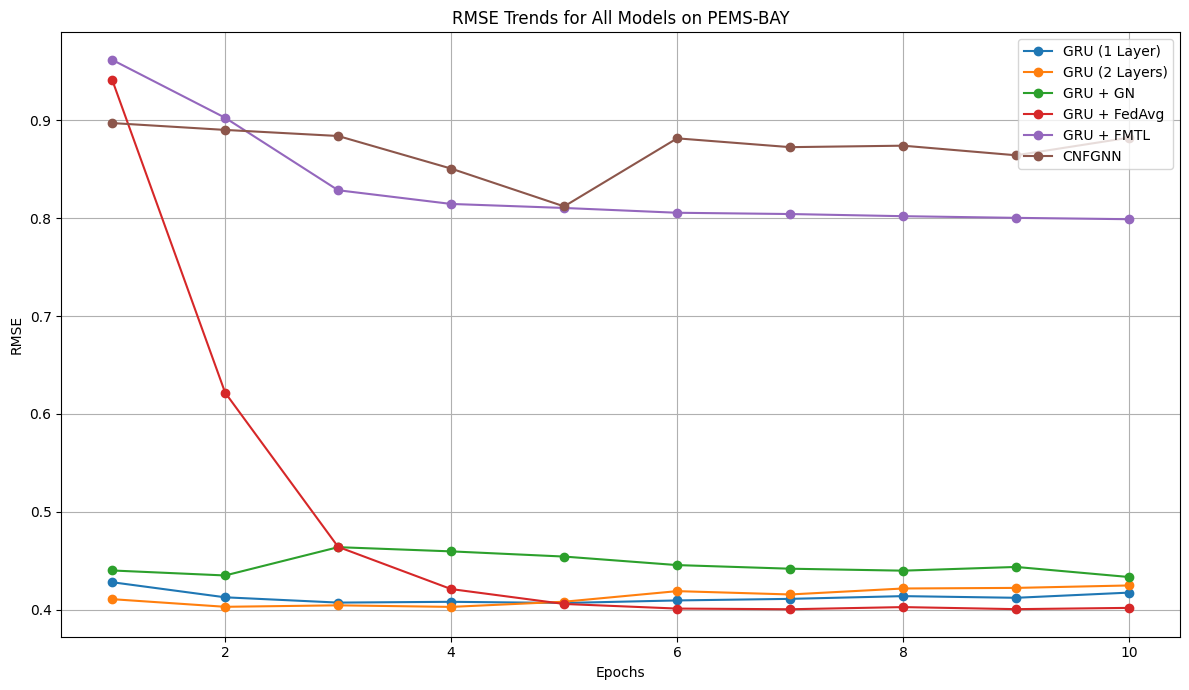

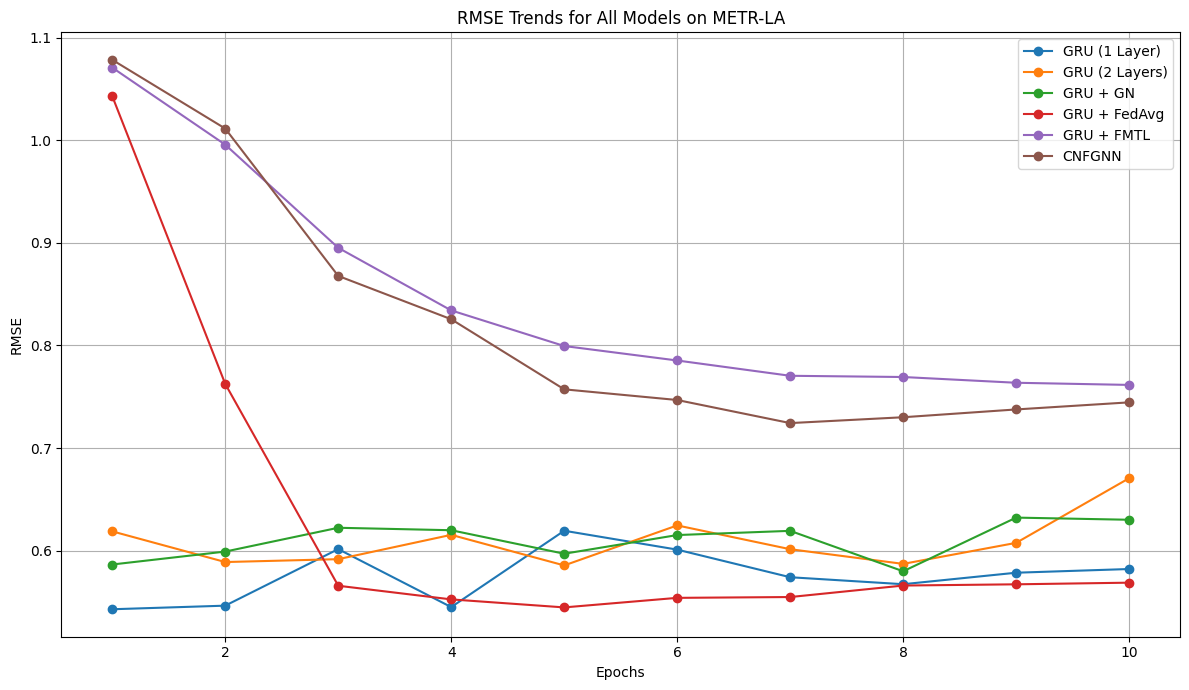


PEMS-BAY RMSE Results:
          GRU (1 Layer)  GRU (2 Layers)  GRU + GN  GRU + FedAvg  GRU + FMTL  \
Epoch 1          0.4282          0.4109    0.4402        0.9414      0.9617   
Epoch 2          0.4128          0.4031    0.4351        0.6218      0.9025   
Epoch 3          0.4074          0.4046    0.4640        0.4643      0.8285   
Epoch 4          0.4082          0.4030    0.4597        0.4212      0.8145   
Epoch 5          0.4070          0.4083    0.4544        0.4060      0.8104   
Epoch 6          0.4096          0.4191    0.4457        0.4013      0.8055   
Epoch 7          0.4112          0.4157    0.4420        0.4006      0.8042   
Epoch 8          0.4140          0.4218    0.4400        0.4028      0.8020   
Epoch 9          0.4123          0.4224    0.4438        0.4007      0.8003   
Epoch 10         0.4176          0.4249    0.4335        0.4020      0.7989   

          CNFGNN  
Epoch 1   0.8971  
Epoch 2   0.8901  
Epoch 3   0.8839  
Epoch 4   0.8506  
Epoch 5   0

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


# Plot RMSE trends for all models
for dataset, models in results.items():
    plt.figure(figsize=(12, 7))
    for model, rmse_values in models.items():
        plt.plot(range(1, 11), rmse_values, label=model, marker='o')
    plt.title(f"RMSE Trends for All Models on {dataset}")
    plt.xlabel("Epochs")
    plt.ylabel("RMSE")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create tables for RMSE results
pems_bay_table = pd.DataFrame(results["PEMS-BAY"], index=[f"Epoch {i}" for i in range(1, 11)])
metr_la_table = pd.DataFrame(results["METR-LA"], index=[f"Epoch {i}" for i in range(1, 11)])

# Display the tables in the output
print("\nPEMS-BAY RMSE Results:")
print(pems_bay_table)

print("\nMETR-LA RMSE Results:")
print(metr_la_table)
